# 每個人在再評估的時候的答案調整分析，比如：有多少%原本在[提升本港回收效能成效]態度中 選擇偏向滿意選項(選項3&4)的受訪者 改選了 偏向不滿意的選項(選項1&2)

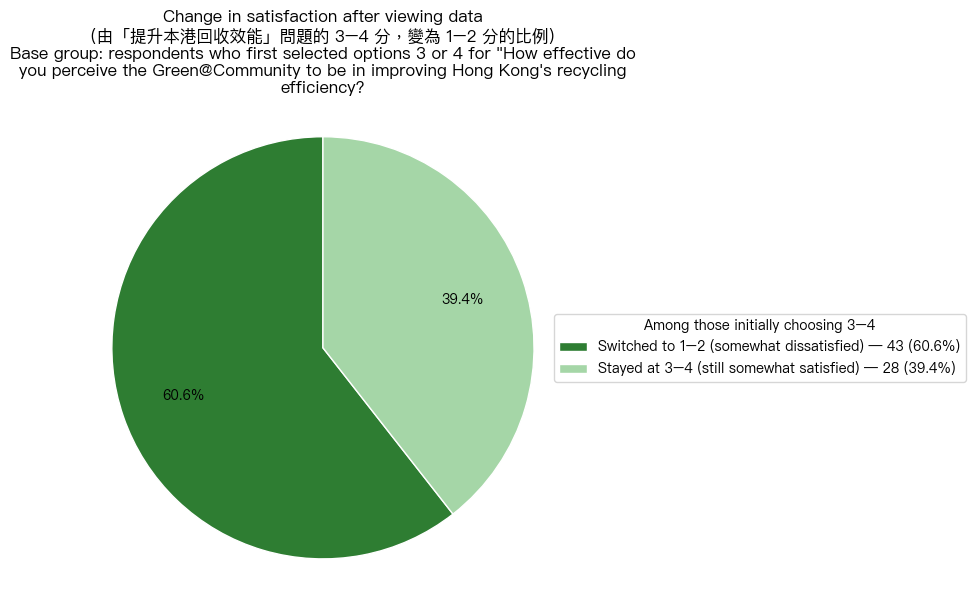

In [7]:
# ------------------------------------------------------------
# Pie chart:
# "What percentage of respondents who originally chose
#  “somewhat satisfied” (options 3 & 4) for
#  [Improving local recycling efficiency]
#  later switched to “somewhat dissatisfied”
#  (options 1 & 2)?"
#
# How to run in 1.2 notebook or VS Code:
#   - Make sure ../GCAP3226 G@C Survey Responses_cleaned data.xlsx exists
#   - Run this cell / script; it shows ONE pie chart and prints nothing.
# ------------------------------------------------------------

# ---------- install deps if missing ----------
import importlib, subprocess, sys
def _ensure(pkg, mod=None):
    try:
        importlib.import_module(mod or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("pandas")
_ensure("openpyxl")
_ensure("matplotlib")

# ---------- imports ----------
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
from textwrap import wrap

# ---------- load data ----------
data_path = Path("../GCAP3226 G@C Survey Responses_cleaned data.xlsx")
df = pd.read_excel(data_path, engine="openpyxl")

# ---------- helper to find columns by their headers ----------
def find_col(columns, patterns):
    cols = [(c, re.sub(r"\s+", " ", str(c)).strip()) for c in columns]
    for c, norm in cols:
        for p in patterns:
            if re.search(p, norm, flags=re.IGNORECASE):
                return c
    return None

# column: effectiveness in improving HK's recycling efficiency
eff_patterns = [
    r"how\s+effective\s+do\s+you\s+perceive\s+the\s+green@community\s+to\s+be\s+in\s+improving\s+hong\s*kong'?s?\s+recycling\s+efficiency",
    r"你認為.*綠在區區.*提升.*本港.*回收效能.*成效.*如何",
]
eff_col = find_col(df.columns, eff_patterns)
if eff_col is None:
    raise RuntimeError("Could not find the 'improving recycling efficiency' column.")

# column: overall effectiveness satisfactory
sat_patterns = [
    r"after\s+reading\s+the\s+above.*overall\s+effectiveness\s+is\s+satisfactory",
    r"在了解以上數據.*整體效益.*滿意",
]
sat_col = find_col(df.columns, sat_patterns)
if sat_col is None:
    raise RuntimeError("Could not find the 'overall effectiveness satisfactory' column.")

# ---------- map responses (1–4) ----------
def to_num(v):
    s = str(v).strip()
    if not s:
        return None
    try:
        n = int(s)
        if 1 <= n <= 4:
            return n
    except ValueError:
        return None
    return None

eff_nums = df[eff_col].map(to_num)
sat_nums = df[sat_col].map(to_num)

# keep rows where both questions are valid 1–4
mask_valid = eff_nums.notna() & sat_nums.notna()
eff_valid = eff_nums[mask_valid].astype(int)
sat_valid = sat_nums[mask_valid].astype(int)

# ---------- people who were initially "somewhat satisfied" (3 or 4) ----------
mask_initial_sat = eff_valid.isin([3, 4])
initial_sat_eff = eff_valid[mask_initial_sat]
later_sat = sat_valid[mask_initial_sat]

base_count = int(mask_initial_sat.sum())

# among them, who later chose "somewhat dissatisfied" (1 or 2)?
switched_count = int((later_sat.isin([1, 2])).sum())
stayed_count = base_count - switched_count

counts = [switched_count, stayed_count]
labels = [
    "Switched to 1–2 (somewhat dissatisfied)",
    "Stayed at 3–4 (still somewhat satisfied)",
]

# ---------- fonts (Chinese-capable if available) ----------
for font_name in ["Noto Sans CJK TC", "PingFang TC", "PingFang HK",
                  "Microsoft JhengHei", "SimHei"]:
    if any(font_name in f.name for f in matplotlib.font_manager.fontManager.ttflist):
        plt.rcParams["font.family"] = font_name
        break
plt.rcParams["axes.unicode_minus"] = False

# ---------- legend labels with counts + percentages ----------
pct = [(c / base_count * 100) if base_count > 0 else 0.0 for c in counts]
legend_labels = [
    f"{labels[i]} — {counts[i]} ({pct[i]:.1f}%)" for i in range(len(labels))
]

# ---------- plot pie chart (same style as previous quiz chart) ----------
fig, ax = plt.subplots(figsize=(9, 6), facecolor="white")
ax.set_facecolor("white")

# colours: dark green for “switched to dissatisfied”, light green for “stayed satisfied”
colors = ["#2e7d32", "#a5d6a7"]

wedges, text_labels, autotexts = ax.pie(
    counts,
    labels=None,  # use legend instead
    colors=colors,
    startangle=90,
    autopct=(lambda p: f"{p:.1f}%") if base_count > 0 else None,
    pctdistance=0.7,
    wedgeprops=dict(edgecolor="white"),
)

ax.legend(
    wedges,
    legend_labels,
    title="Among those initially choosing 3–4",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0.0,
)

title_main = (
    "Change in satisfaction after viewing data\n"
    "（由「提升本港回收效能」問題的 3–4 分，變為 1–2 分的比例）"
)
title_sub = (
    'Base group: respondents who first selected options 3 or 4 for '
    '"How effective do you perceive the Green@Community to be in improving '
    "Hong Kong's recycling efficiency?"
)
wrapped_sub = "\n".join(wrap(title_sub, 80))

ax.set_title(title_main + "\n" + wrapped_sub, pad=16)

ax.axis("equal")  # keep the pie circular
plt.tight_layout()
plt.show()
